# NLP Sentiment Analysis on Stock Transcripts using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import sqlite3
import re

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

/home/jfaile3/.conda/envs/nlp_test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running data using: {device}")

Running data using: cuda


### Load the data

In [3]:
# Create parser function that eliminates everything from the transcripts except the Q&A portion
def dataset_parser_QandA(text):

    QandA_start_str = "and-answer"
    QandA_end_str = "newsview"
    
    # find the start index and end index (add or subtract offset to clean it up)
    start_index = text.find(QandA_start_str)+52
    end_index = text.find(QandA_end_str)-60

    # If start and end indices are found, extract the text in between
    if start_index != -1 and end_index != -1:
        parsed_text = text[start_index:end_index]
    elif start_index != -1 and end_index == -1:
        parsed_text = text[start_index:]
    elif start_index == -1 and end_index != -1:
        parsed_text = text[:end_index]
    else:
        parsed_text = text

    return parsed_text

In [4]:
# Create parser function that eliminates everything from the transcripts except the Q&A portion
# This one is used for debugging and testing.
def test_dataset_parser_QandA(text, only_start_count, only_end_count, none_found_count, both_found_count):

    # QandA_start_str = "question-and-answer session operator"
    # QandA_end_str = "concludes the question-and-answer"

    QandA_start_str = "and-answer"
    QandA_end_str = "newsview"

    # find the start index and end index (add or subtract offset to clean it up)
    start_index = text.find(QandA_start_str)+52
    end_index = text.find(QandA_end_str)-60

    # If start and end indices are found, extract the text in between
    if start_index != -1 and end_index != -1:
        parsed_text = text[start_index:end_index]
        both_found_count += 1
    elif start_index != -1 and end_index == -1:
        parsed_text = text[start_index:]
        only_start_count += 1
    elif start_index == -1 and end_index != -1:
        parsed_text = text[:end_index]
        only_end_count += 1
    else:
        parsed_text = text
        none_found_count += 1

    return parsed_text, only_start_count, only_end_count, none_found_count, both_found_count

In [5]:
# Create parser function that eliminates everything from the transcripts except the Q&A portion
def umair_preprocess_text(text):
    ###Remove extra whitespaces and normalize spaces
    text = re.sub(r'\s+', ' ', text)
    ###Remove leading and trailing whitespaces
    text = text.strip()
    return text

def umair_dataset_parser_QandA(text):
    QandA_start_str = "Question-and-Answer Session"

    text = umair_preprocess_text(text)

    ###Find the start index of "Question-and-Answer Session"
    start_index = text.find(QandA_start_str)
    indicator = 1
    #print(start_index)
    if start_index != -1:
        start_index += len(QandA_start_str)
    else:
      QandA_start_str = "Answer Session"
      start_index = text.find(QandA_start_str)
      if start_index == -1:
        indicator = 0
      else:
        start_index +=  len(QandA_start_str)

    ###If start index is found, extract the text from that point onwards
    if start_index != -1:
        parsed_text = text[start_index:].strip()
    else:
        parsed_text = text.strip()

    return parsed_text,indicator


In [6]:
# Load data from the cloned dataset curation repository
conn = sqlite3.connect('/gv1/users/jfaile3/dl-7643-finalproj-DatasetCuration/transcripts.db')
cursor = conn.cursor()
cursor.execute('SELECT * FROM transcripts')
data = cursor.fetchall() 
conn.close()

# initialize your positive and negative thresholds for the price movement
positive_thres = 3
negative_thres =  -3

# initialize your truth labels
truth_labels = []
parsed_texts = []

# initialize all the data
indices = []
company_names = []
tickers = []
quarters = []
years = []
report_years = []
report_months = []
report_days = []
filenames = []
texts_original = []
texts_cleaned = []
texts_cleaned_no_stopwords = []
texts_cleaned_no_stopwords_stemmed = []
share_prices_t_plus_2 = []
share_prices_t_minus_2 = []
share_prices_t_minus_90 = []
share_prices_t_plus_90 = []
spys_t_plus_2 = []
spys_t_minus_2 = []
spys_t_minus_90 = []
spys_t_plus_90 = []

only_start_count = 0
only_end_count = 0
none_found_count = 0
both_found_count = 0

# Iterate through data by parsing
count = 0
for text_id, row in enumerate(data):

    # extract relevent attributes from the dataset
    index = row[1]
    company_name = row[2]
    ticker = row[3]
    quarter = row[4]
    year = row[5]
    report_year = row[6]
    report_month = row[7]
    report_day = row[8]
    filename = row[9]
    text_original = row[10]
    text_cleaned = row[11]
    text_cleaned_no_stopwords = row[12]
    text_cleaned_no_stopwords_stemmed = row[13]
    # extract the closing share price 2 days after the report
    share_price_t_plus_2 = row[14]
    # extract the closing share price 2 before the report
    share_price_t_minus_2 = row[15]
    share_price_t_minus_90 = row[16]
    share_price_t_plus_90 = row[17]
    spy_t_plus_2 = row[18]
    spy_t_minus_2 = row[19]
    spy_t_minus_90 = row[20]
    spy_t_plus_90 = row[21]

    # calculate the price movement
    price_movement = ((share_price_t_plus_2 - share_price_t_minus_2) / share_price_t_minus_2)*100

    # generate truth label for this transcript
    if price_movement < negative_thres:
        truth_label = 0 # negative
    elif price_movement < positive_thres:
        truth_label = 1 # neutral
    else:
        truth_label = 2 # positive

    # parse the text and cut out excess
    # parsed_text = dataset_parser_QandA(text_original)
    # parsed_text, only_start_count, only_end_count, none_found_count, both_found_count = test_dataset_parser_QandA(text_cleaned, only_start_count, only_end_count, none_found_count, both_found_count)
    parsed_text, indicator = umair_dataset_parser_QandA(text_original)

    indices.append(index)
    company_names.append(company_name)
    tickers.append(ticker)
    quarters.append(quarter)
    years.append(year)
    report_years.append(report_year)
    report_months.append(report_month)
    report_days.append(report_day)
    filenames.append(filename)
    texts_original.append(text_original)
    texts_cleaned.append(text_cleaned)
    texts_cleaned_no_stopwords.append(text_cleaned_no_stopwords)
    texts_cleaned_no_stopwords_stemmed.append(text_cleaned_no_stopwords_stemmed)
    share_prices_t_plus_2.append(share_price_t_plus_2)
    share_prices_t_minus_2.append(share_price_t_minus_2)
    share_prices_t_minus_90.append(share_price_t_minus_90)
    share_prices_t_plus_90.append(share_price_t_plus_90)
    spys_t_plus_2.append(spy_t_plus_2)
    spys_t_minus_2.append(spy_t_minus_2)
    spys_t_minus_90.append(spy_t_minus_90)
    spys_t_plus_90.append(spy_t_plus_90)

    # append all data to lists for final metric evaluation
    truth_labels.append(truth_label)
    parsed_texts.append(parsed_text)

    # count = count + 1
    # if count == 20:
    #     break

# Creating a dictionary with your data
data = {
    'truth_labels': truth_labels,
    'parsed_texts': parsed_texts,
    'indices': indices,
    'company_names': company_names,
    'tickers': tickers,
    'quarters': quarters,
    'years': years,
    'report_years': report_years,
    'report_months': report_months,
    'report_days': report_days,
    'filenames': filenames,
    'texts_original': texts_original,
    'texts_cleaned': texts_cleaned,
    'texts_cleaned_no_stopwords': texts_cleaned_no_stopwords,
    'texts_cleaned_no_stopwords_stemmed': texts_cleaned_no_stopwords_stemmed,
    'share_prices_t_plus_2': share_prices_t_plus_2,
    'share_prices_t_minus_2': share_prices_t_minus_2,
    'share_prices_t_minus_90': share_prices_t_minus_90,
    'share_prices_t_plus_90': share_prices_t_plus_90,
    'spys_t_plus_2': spys_t_plus_2,
    'spys_t_minus_2': spys_t_minus_2,
    'spys_t_minus_90': spys_t_minus_90,
    'spys_t_plus_90': spys_t_plus_90
}

# print(parsed_texts[57])
# print(truth_labels[57])

# print(parsed_texts[0])
# print(truth_labels[0])

# print(f'{both_found_count} parsed with both found.')
# print(f'{none_found_count} parsed with none found.')
# print(f'{only_end_count} parsed with only end found.')
# print(f'{only_start_count} parsed with only start found.')

# Create dataframe
df = pd.DataFrame(data)
df.shape


(1570, 23)

In [7]:
# Examine the data
df.head()

,truth_labels,parsed_texts,indices,company_names,tickers,quarters,years,report_years,report_months,report_days,...,texts_cleaned_no_stopwords,texts_cleaned_no_stopwords_stemmed,share_prices_t_plus_2,share_prices_t_minus_2,share_prices_t_minus_90,share_prices_t_plus_90,spys_t_plus_2,spys_t_minus_2,spys_t_minus_90,spys_t_plus_90
0,0,Operator [Operator Instructions] Our first que...,0,3M,MMM,1,2023,2023,4,25,...,3m company mmm q1 2023 earnings call transcrip...,3m compani mmm q1 2023 earn call transcript se...,105.33,112.93,412.41,400.35,104.48,104.27,412.20,454.20
1,2,Operator [Operator Instructions] Our first que...,1,3M,MMM,2,2023,2023,7,25,...,3m company mmm q2 2023 earnings call transcrip...,3m compani mmm q2 2023 earn call transcript se...,111.19,102.92,452.49,404.36,104.33,85.60,452.18,420.46
2,0,Operator [Operator Instructions] Our first que...,2,3M,MMM,3,2023,2023,10,24,...,3m company mmm q3 2023 earnings call transcrip...,3m compani mmm q3 2023 earn call transcript se...,88.65,112.64,412.55,455.51,86.55,108.02,421.19,483.45
3,2,Operator [Operator Instructions] And our first...,3,3M,MMM,4,2023,2024,1,23,...,3m company mmm q4 2023 earnings call transcrip...,3m compani mmm q4 2023 earn call transcript se...,95.98,89.39,488.03,417.55,107.76,91.05,482.43,503.53
4,2,Operator Thank you. [Operator Instructions] Ou...,4,A. O. Smith,AOS,1,2023,2023,4,27,...,smith corporation aos q1 2023 earnings call tr...,smith corpor ao q1 2023 earn call transcript s...,70.14,60.36,415.51,405.68,68.57,75.07,406.08,455.51


We will be alloting three classes:

    Class 0: Negative
    Class 1: Neutral
    Class 2: Positive

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

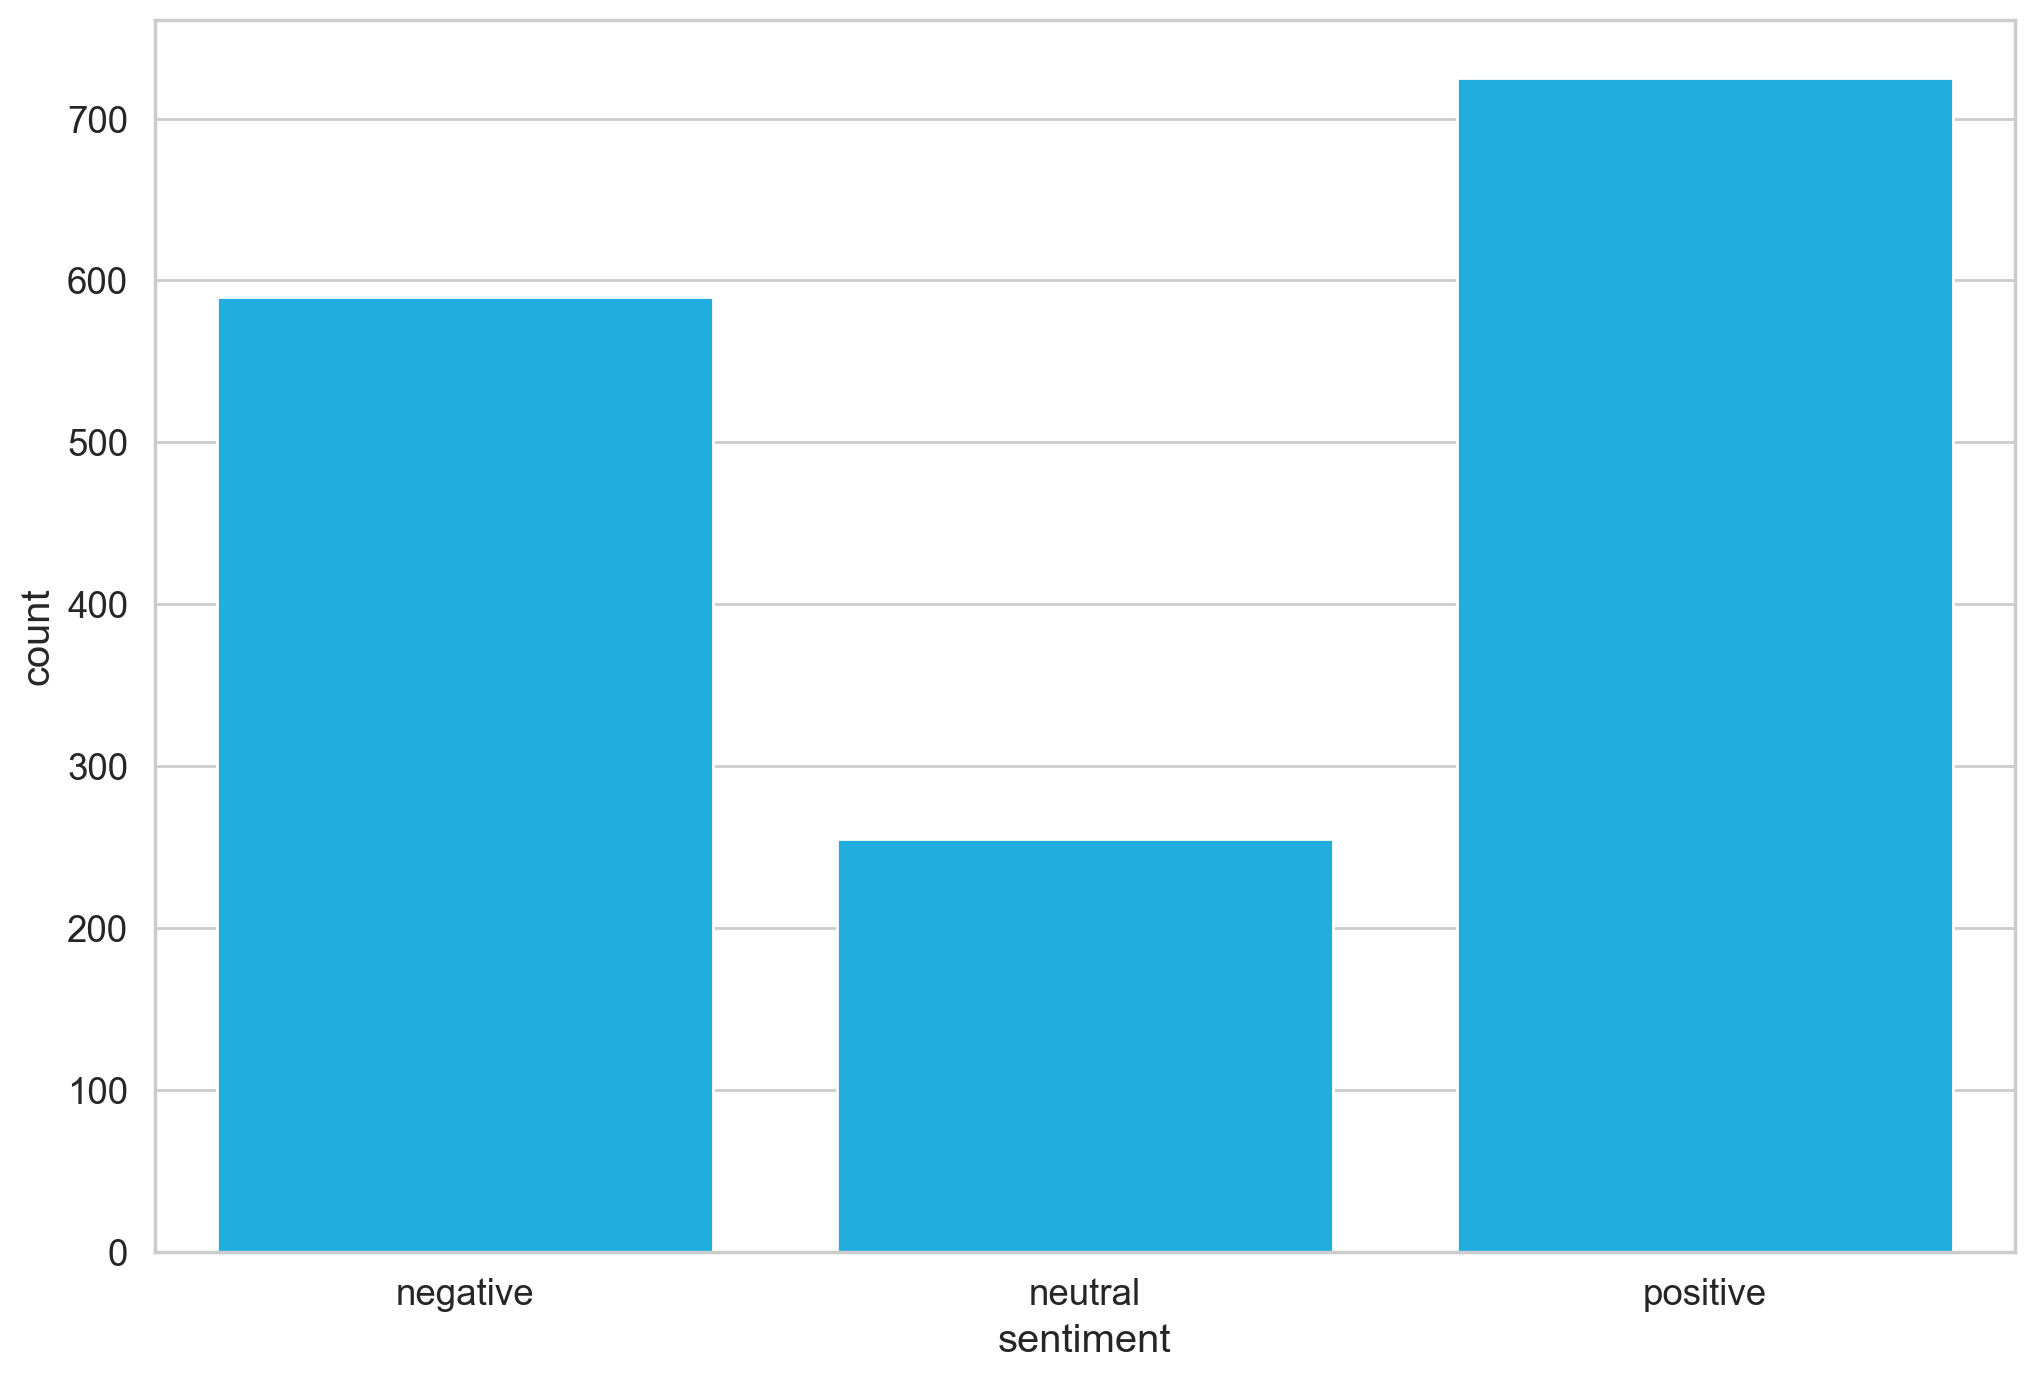

In [8]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df, x='truth_labels')
plt.xlabel('sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [9]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

class_names = ['negative', 'neutral', 'positive']

In [10]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. Here we store the token length of each transcript for analysis.

In [11]:
# Store length of each transcript 
token_lens = []

# Iterate through the parsed texts
for txt in df.parsed_texts:
    # tokens = tokenizer.encode(txt, max_length=512)
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (9142 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 0, 'Token count')

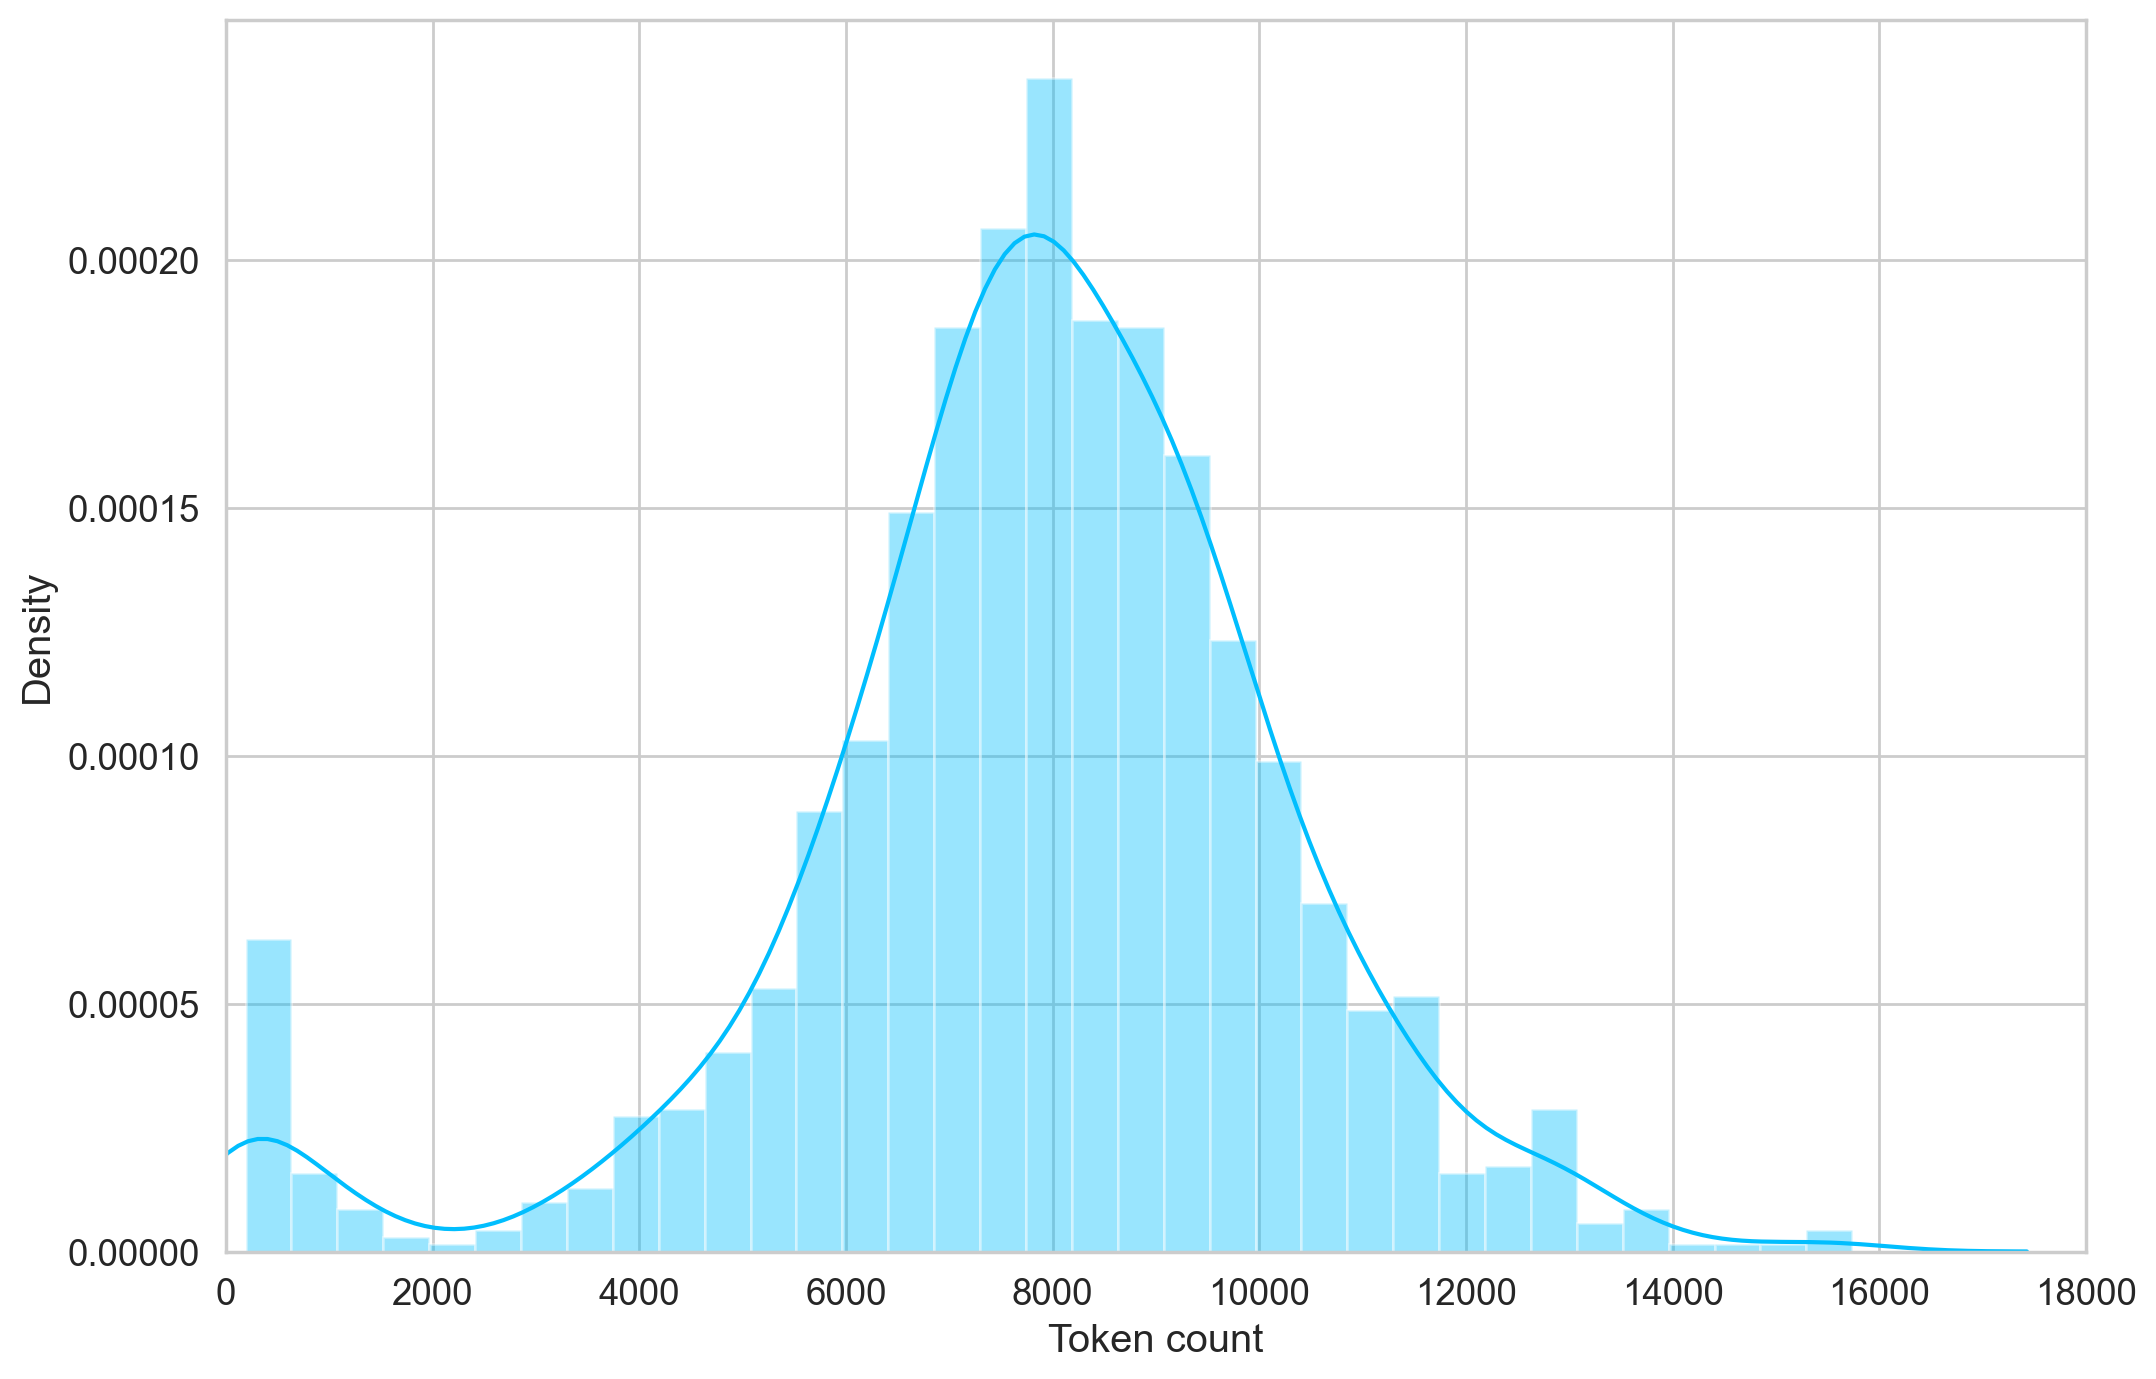

In [12]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 18000]);
plt.xlabel('Token count')

Due to the shear amount of tokens in this dataset, we will set the max length to the largest that this model can handle.

In [128]:
MAX_LEN = 512
# Selected hyperparameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.00001 #2e-5

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [129]:
# Create data generator class
class TranscriptDataset(Dataset):
    # Constructor Function 
    def __init__(self, transcripts, targets, tokenizer, max_len):
        self.transcripts = transcripts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.transcripts)
    
    # get item magic method
    def __getitem__(self, item):
        transcript = str(self.transcripts[item])
        target = self.targets[item]

        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            transcript,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        input_ids = encoding['input_ids'].flatten()
        attention_masks = encoding['attention_mask'].flatten()
        targets = torch.tensor(target, dtype=torch.long)
        
        return {
            'transcript_text': transcript,
            'input_ids': input_ids,
            'attention_mask': attention_masks,
            'targets': targets
        }

Create a 80% train data and 10% test and 10% validation data

In [130]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)

print(df_train.shape, df_val.shape, df_test.shape)

(1256, 23) (157, 23) (157, 23)


Create a dataloader to release data in batches.

In [131]:
# Create dataloader to release data in batches
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TranscriptDataset(
        transcripts=df.parsed_texts.to_numpy(),
        targets=df.truth_labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [132]:
# Create train, test and val data loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [133]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['transcript_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])


## Sentiment Classification with BERT and Hugging Face

Here we will use the basic BertModel and build our sentiment classifier on top of it.

In [134]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = bert_output.pooler_output # Accessing the pooled output
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU if possible.

In [135]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [136]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

We will use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [137]:
# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [138]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    # Iterate through each batch in the full training dataset
    for d in data_loader:

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs, targets)
        
        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [139]:
# Evaluation function for training
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [140]:
# Training Loop

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), f"best_bert_model_state.bin")
        best_accuracy = val_acc

Epoch 1/50
----------
Train loss 1.0858737453818321 accuracy 0.4315286624203822
Val   loss 1.0401904463768006 accuracy 0.47770700636942676

Epoch 2/50
----------
Train loss 1.0581277057528495 accuracy 0.4052547770700637
Val   loss 0.9612980604171752 accuracy 0.49044585987261147

Epoch 3/50
----------
Train loss 1.0566536113619804 accuracy 0.4315286624203822
Val   loss 0.9482026696205139 accuracy 0.4840764331210191

Epoch 4/50
----------
Train loss 1.0502162382006646 accuracy 0.4418789808917198
Val   loss 0.9424855232238769 accuracy 0.49044585987261147

Epoch 5/50
----------
Train loss 1.0490299388766289 accuracy 0.4538216560509554
Val   loss 0.9396236658096313 accuracy 0.5286624203821656

Epoch 6/50
----------
Train loss 1.0232591688632966 accuracy 0.5015923566878981
Val   loss 0.9199532270431519 accuracy 0.5286624203821656

Epoch 7/50
----------
Train loss 0.9932331994175911 accuracy 0.5533439490445861
Val   loss 1.0104824423789978 accuracy 0.4585987261146497

Epoch 8/50
----------
Tr

We can plot the training and validation accuracy and loss.

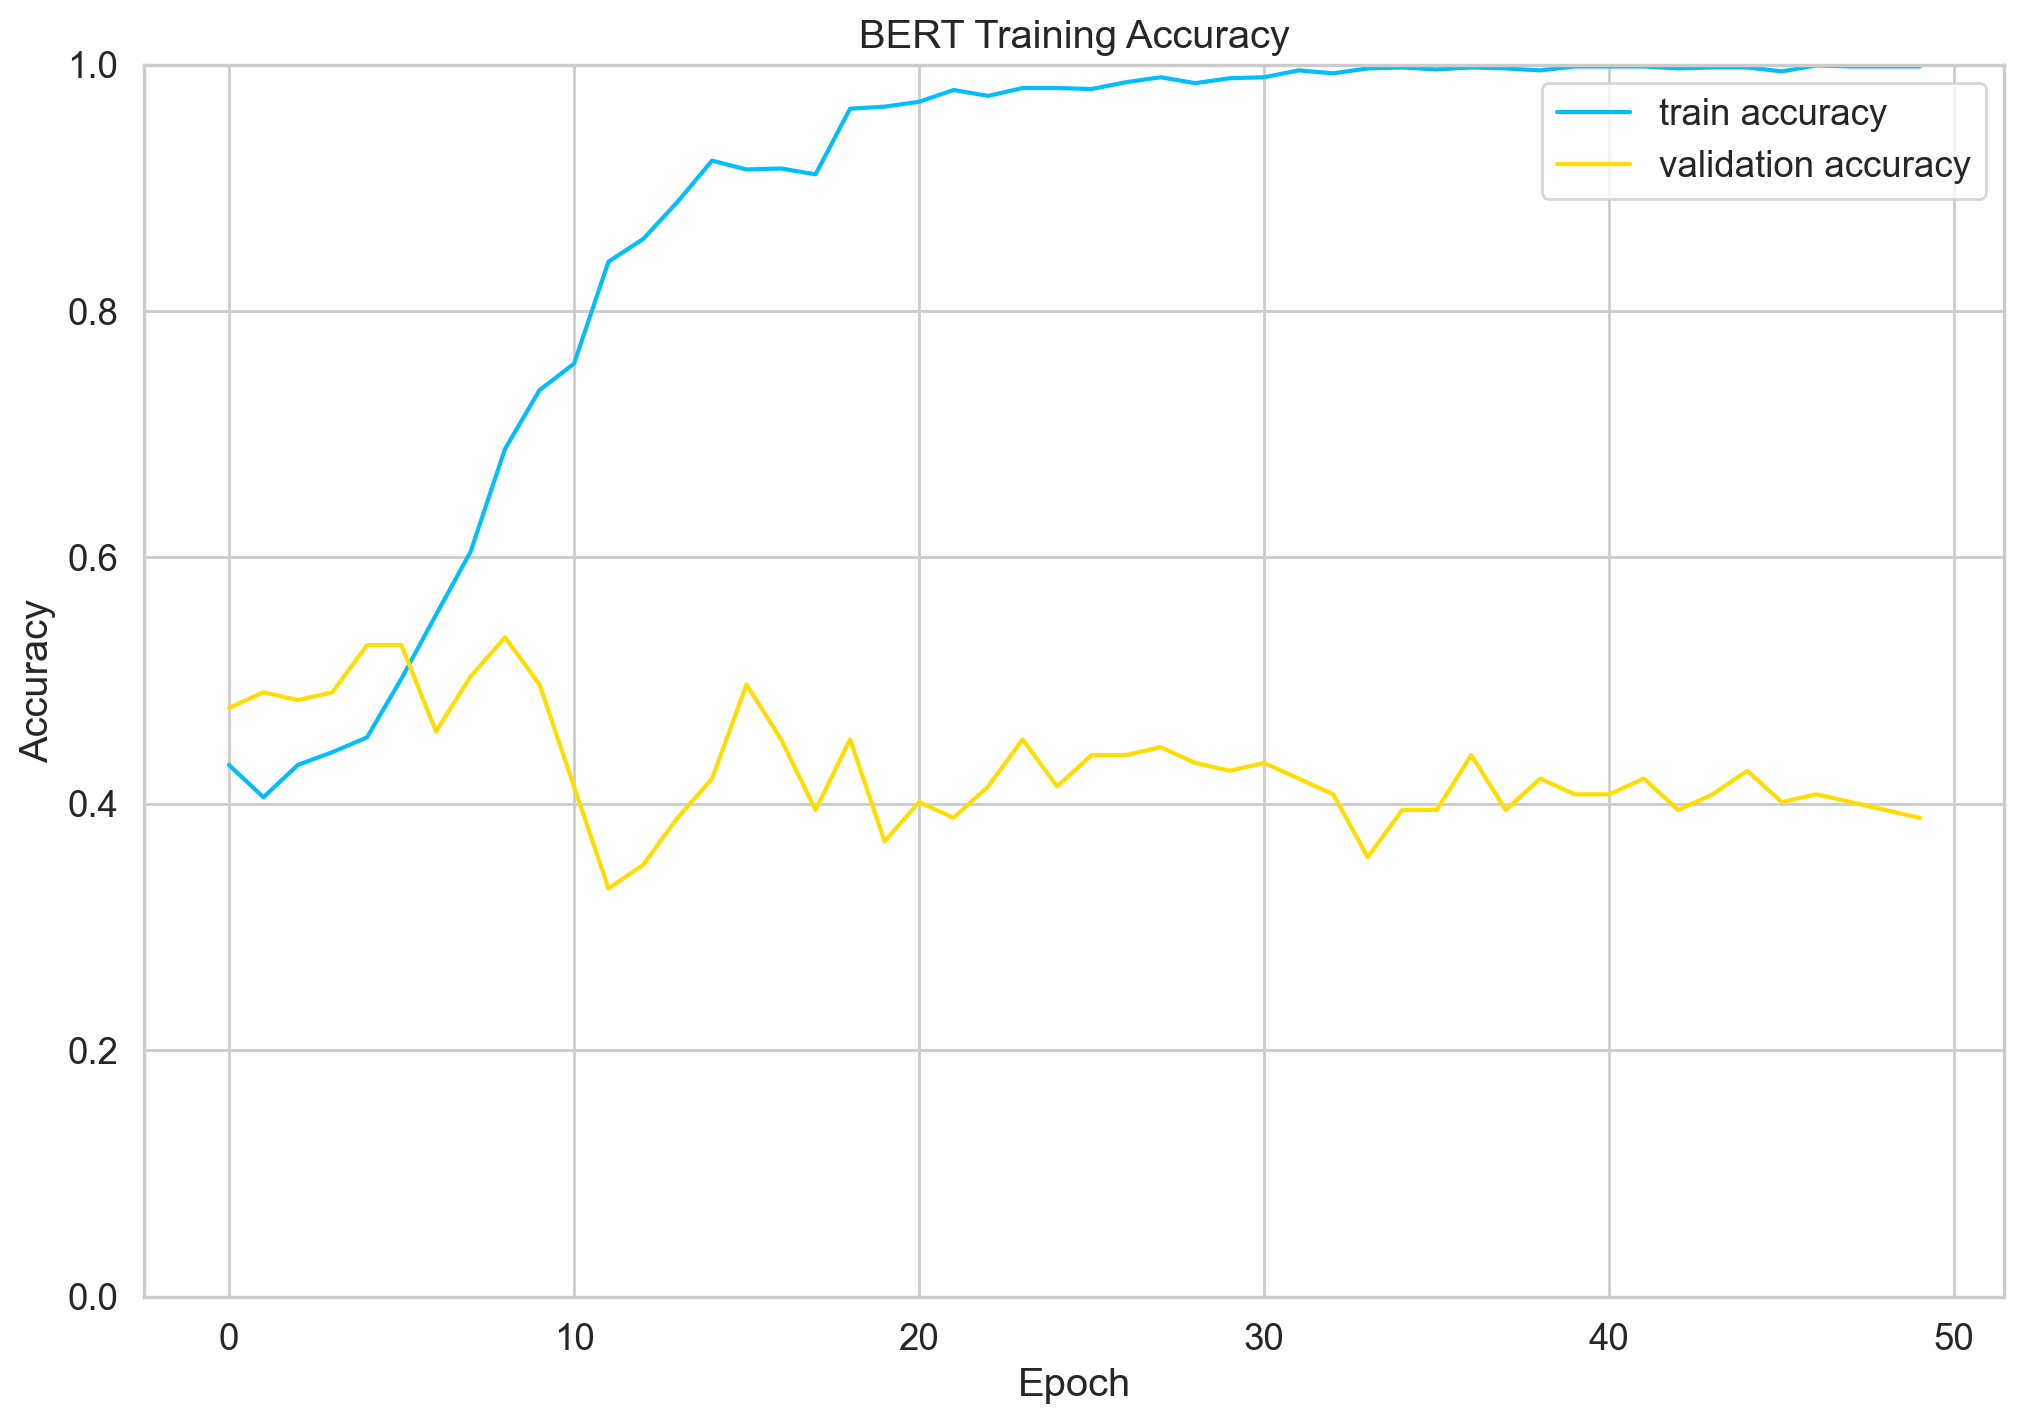

In [141]:
# Plot Training Accuracy Results
# Add in this to copy the tensor to host memory first
history['train_acc'] = [x.cpu() for x in history['train_acc']]
history['val_acc'] = [x.cpu() for x in history['val_acc']]

# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('BERT Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# Show the plot
plt.show()

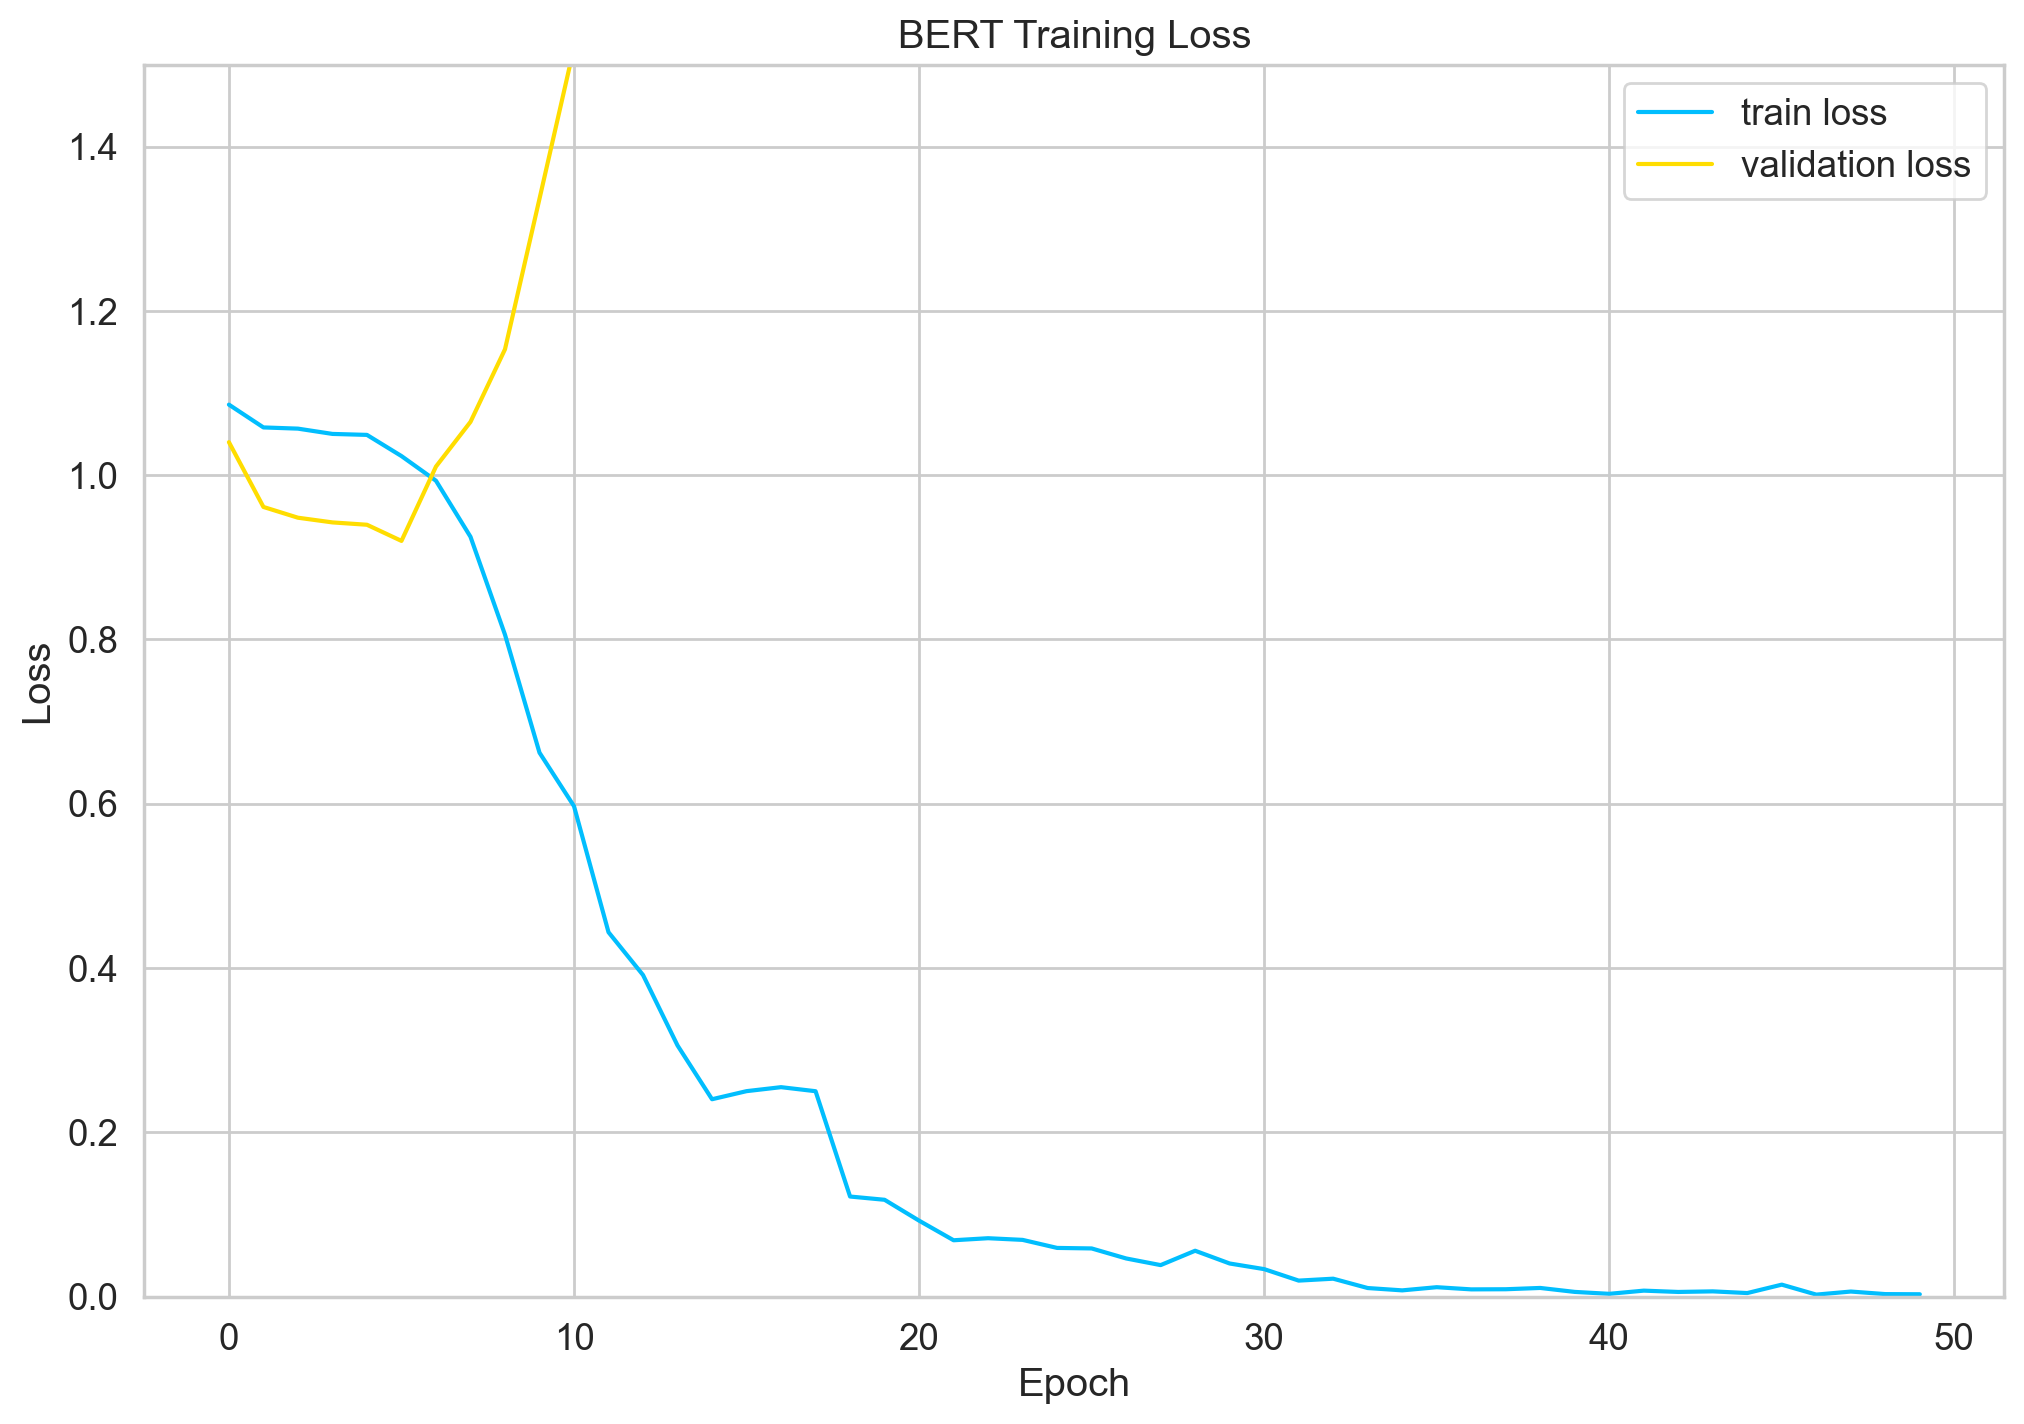

In [142]:
# Plot Training Loss Results
# Add in this to copy the tensor to host memory first
history['train_loss'] = [x for x in history['train_loss']]
history['val_loss'] = [x for x in history['val_loss']]

# Plot training and validation accuracy
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

# Graph chars
plt.title('BERT Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.5])

# Show the plot
plt.show()

### Model Evaluation

In [143]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.3885350318471338

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the transcripts and the predicted probabilities

In [144]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["transcript_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [145]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [146]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.45      0.38      0.41        60
     neutral       0.16      0.44      0.23        18
    positive       0.55      0.38      0.45        79

    accuracy                           0.39       157
   macro avg       0.38      0.40      0.36       157
weighted avg       0.46      0.39      0.41       157



In [147]:
def evaluate_classification(truth_labels, predicted_labels):
    # Calculate accuracy
    accuracy = accuracy_score(truth_labels, predicted_labels)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(truth_labels, predicted_labels, average='macro')
    recall = recall_score(truth_labels, predicted_labels, average='macro')
    f1 = f1_score(truth_labels, predicted_labels, average='macro')
    
    # Calculate confusion matrix
    cm = confusion_matrix(truth_labels, predicted_labels)
    
    return accuracy, precision, recall, f1, cm

# evaluate the truth and predicted data and generate metrics
accuracy, precision, recall, f1, cm = evaluate_classification(y_test, y_pred)

print('-----------------------------Metrics-----------------------------')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(cm)

-----------------------------Metrics-----------------------------
Accuracy: 0.3885350318471338
Precision: 0.38443256090314915
Recall: 0.4025082044069386
F1-score: 0.36468655547175993
Confusion Matrix:
[[23 17 20]
 [ 5  8  5]
 [23 26 30]]


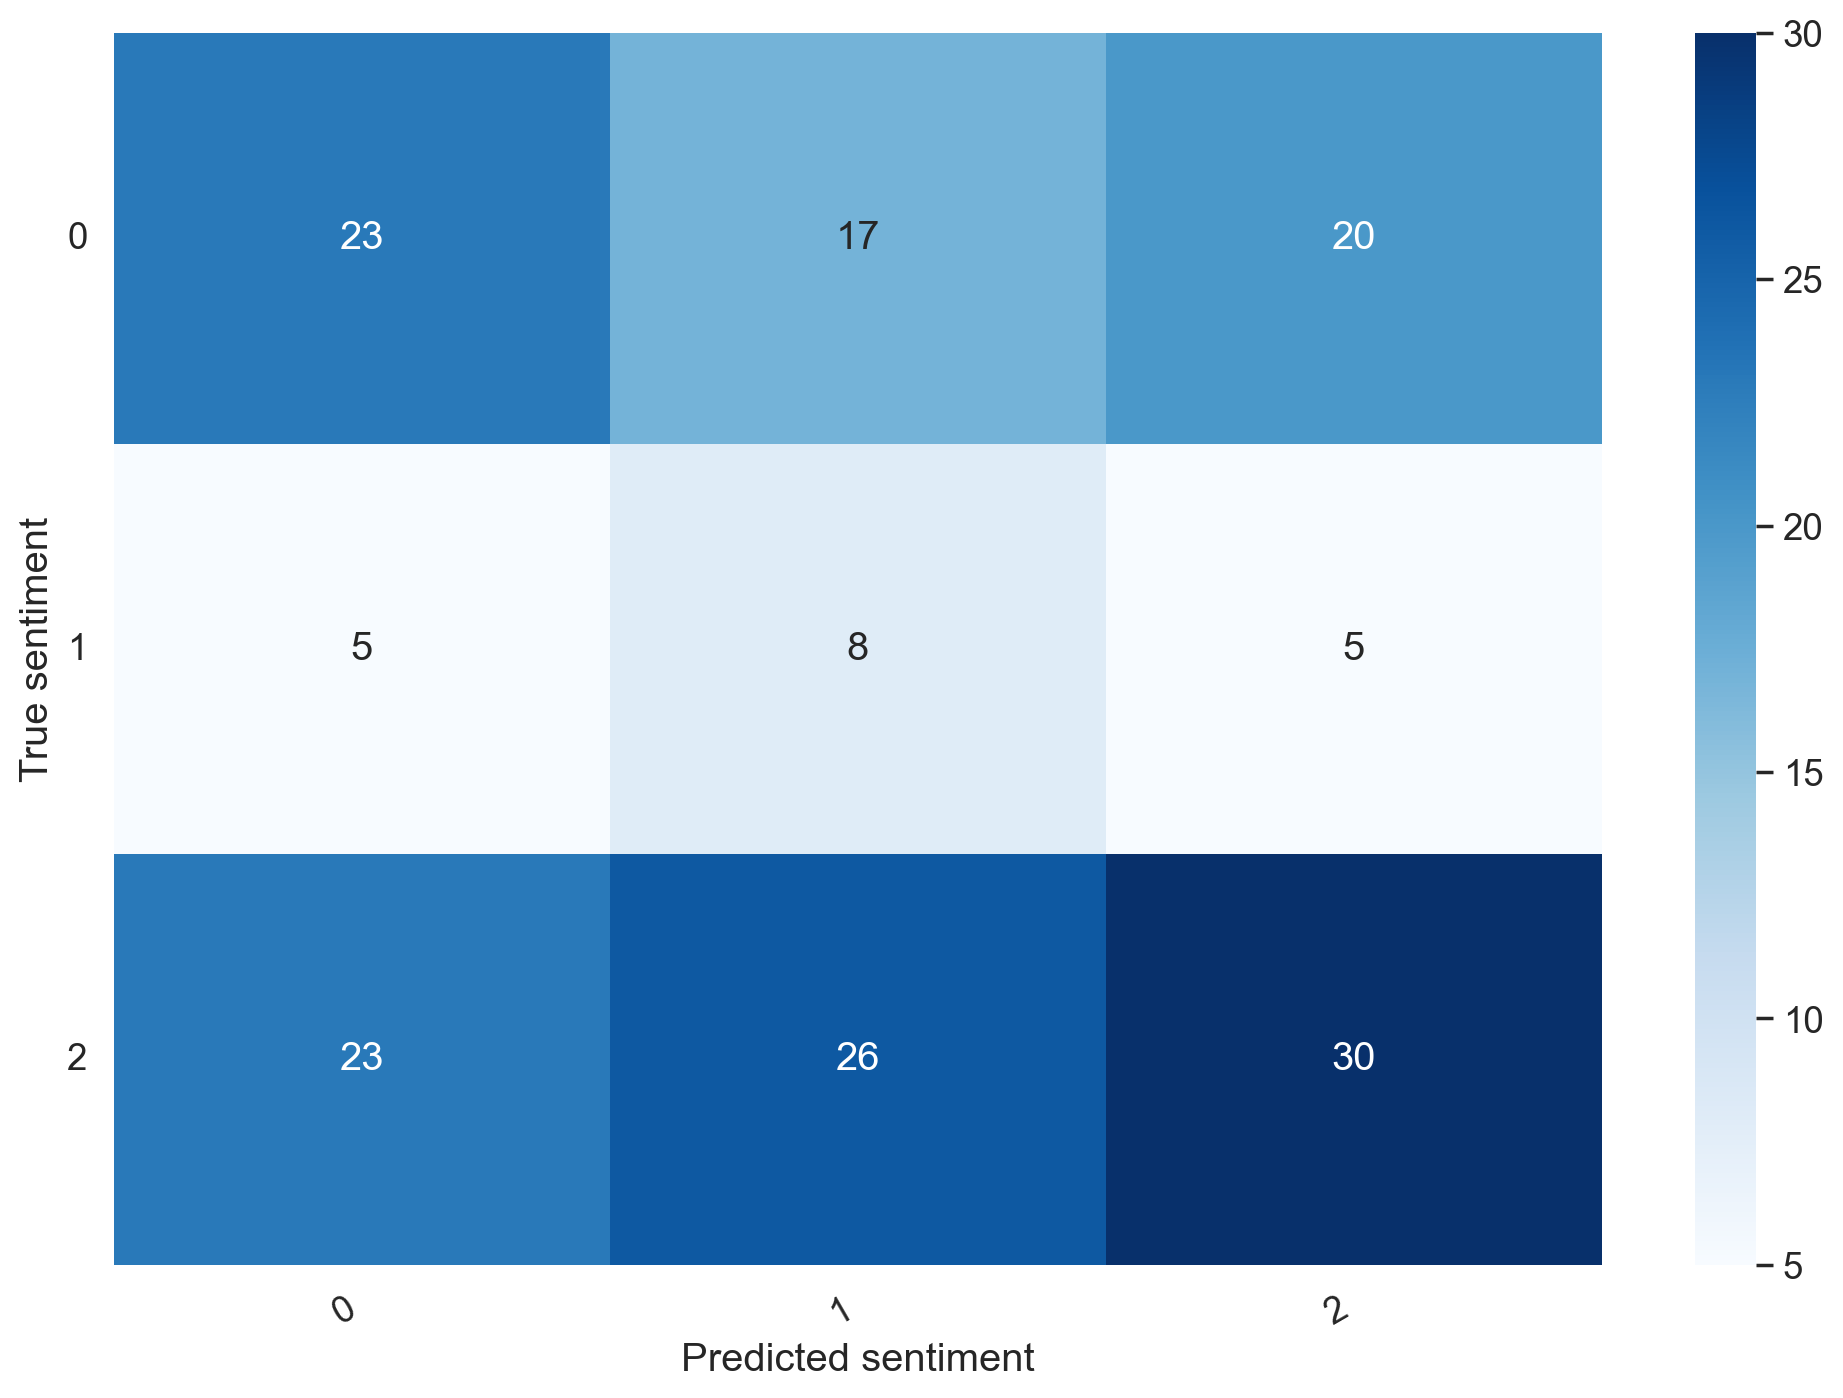

In [148]:
def show_confusion_matrix(confusion_matrix):
    # plt.figure(figsize=(4,3))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
    plt.show()

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [149]:
def get_metrics(pred_labels, true_labels):

  # Calculate accuracy
  accuracy = accuracy_score(true_labels, pred_labels)

  # Calculate confusion matrix
  conf_matrix = confusion_matrix(true_labels, pred_labels)

  plot_confusion_matrix(conf_matrix)

  # Print accuracy and confusion matrix
  print("Accuracy:", accuracy)
  #print("Confusion Matrix:")
  #print(conf_matrix)

  # Generate classification report (includes precision, recall, and F1 score)
  class_report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
  plot_classification_report(class_report)

  #print("Classification Report:")
  #print(class_report)

  return accuracy


def plot_confusion_matrix(matrix):
  title = "Confusion Matrix for BERT Model"
  plt.figure(figsize=(4, 3))
  sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
  plt.title(title)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()
  plt.clf()

def plot_classification_report(class_report):
  title = "Classification Report for BERT Model"
  plt.figure(figsize=(4, 3))
  sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)
  plt.title(title)
  plt.xlabel('Metrics')
  plt.ylabel('Classes')
  plt.show()
  plt.clf()

def plot_losses(epochs, train_loss, val_loss):
  title = "Training vs Validation Loss for BERT"
  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()
  plt.show()

def plot_accuracy(epochs, val_acc):
  title = "Validation Accuracies for BERT"
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.legend()
  plt.show()

     


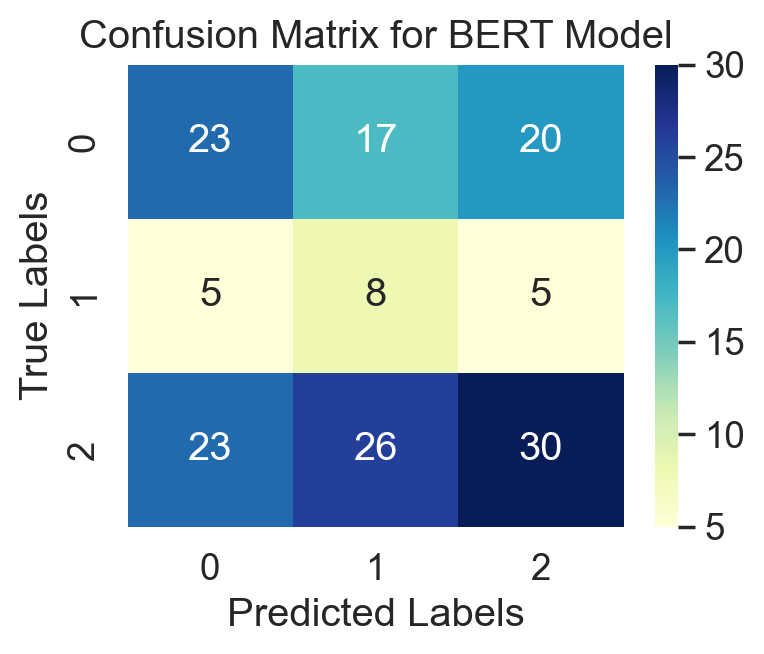

Accuracy: 0.3885350318471338


<Figure size 1200x800 with 0 Axes>

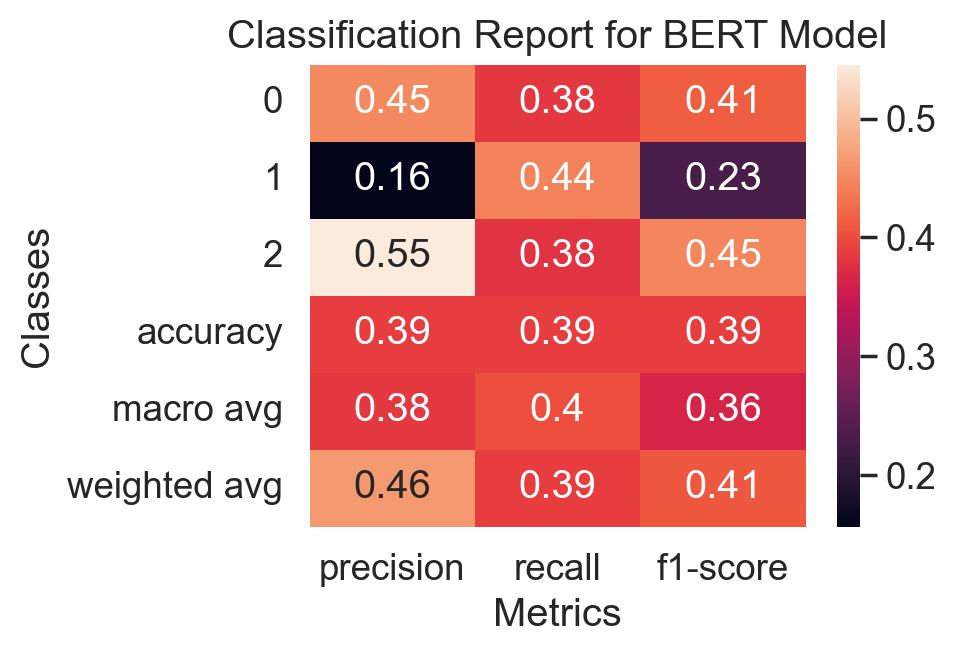

0.3885350318471338

<Figure size 1200x800 with 0 Axes>

In [150]:
get_metrics(y_pred, y_test)

## Predicting on raw text

In [95]:
transcript_text = "We had a great year. Our work was very successful overall."

In [96]:
encoded_transcript = tokenizer.encode_plus(
    transcript_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [97]:
input_ids = encoded_transcript['input_ids'].to(device)
attention_mask = encoded_transcript['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Transcript text: {transcript_text}')
print(f'Sentiment  : {class_names[prediction]}')

Transcript text: We had a great year. Our work was very successful overall.
Sentiment  : positive
